<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/NorthwesternHeader.png?raw=1" />

## MSDS458 Research Assignment 02 - Part 1
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Imports

In [ ]:
import numpy as np
import pandas as pd
import datetime
from packaging import version

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.15.0


## Mount Google Drive to Colab Environment

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

## EDA Functions

In [ ]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)

    x = x[indices]
    y = y[indices]

    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)

    x = x[indices]
    y = y[indices]

    y = tf.keras.utils.to_categorical(y)

    return x, y

In [ ]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)

    x = x[indices]
    y = y[indices]
    p = p[indices]

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [ ]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

In [ ]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions))))

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test
* Imported 50000 labels for training and 10000 labels for test

In [ ]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


## Review Labels

In [ ]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


## Plot Subset of Examples

In [ ]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [ ]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

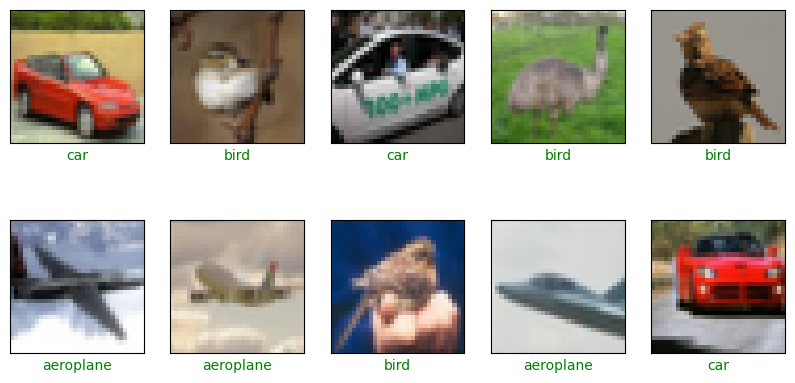

In [ ]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [ ]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [ ]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [ ]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255


1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [ ]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

## Create the Model

## Experiment 2 Build DNN Model with 3 layers

Deep Neural Network (DNN) with 3 layers (no regularization) using TensorFlow

In [ ]:
k.clear_session()

# Create the model
model = Sequential([
    Flatten(input_shape=(32, 32, 3)),  # Adjusting input shape according to the dataset
    Dense(units=128, activation='relu'),  # First hidden layer with 128 units
    Dense(units=64, activation='relu'),   # Second hidden layer with 64 units
    Dense(units=32, activation='relu'),   # Third hidden layer with 32 units
    Dense(units=10, activation='softmax') # Output layer with 10 units (for 10 classes)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 404010 (1.54 MB)
Trainable params: 404010 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


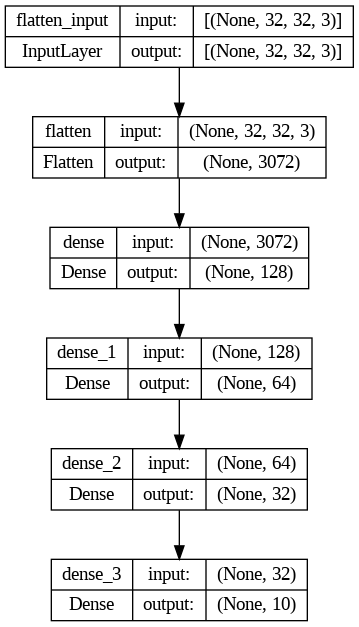

In [ ]:
tf.keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True)

## Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
# Train the model with specified parameters
history = model.fit(
    x_train_norm, y_train_split,
    epochs=200,
    batch_size=64,
    validation_data=(x_valid_norm, y_valid_split),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("DNN_model.h5", save_best_only=True, save_weights_only=False),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]
)

Epoch 1/200
704/704 [==============================] - 5s 4ms/step - loss: 1.9119 - accuracy: 0.2997 - val_loss: 1.8244 - val_accuracy: 0.3438
Epoch 2/200
 55/704 [=>............................] - ETA: 1s - loss: 1.7661 - accuracy: 0.3611

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


704/704 [==============================] - 2s 3ms/step - loss: 1.7340 - accuracy: 0.3725 - val_loss: 1.7154 - val_accuracy: 0.3718
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6610 - accuracy: 0.4016 - val_loss: 1.6541 - val_accuracy: 0.4024
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6064 - accuracy: 0.4240 - val_loss: 1.6061 - val_accuracy: 0.4196
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5678 - accuracy: 0.4362 - val_loss: 1.5982 - val_accuracy: 0.4186
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5415 - accuracy: 0.4481 - val_loss: 1.5621 - val_accuracy: 0.4376
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5134 - accuracy: 0.4590 - val_loss: 1.5695 - val_accuracy: 0.4298
Epoch 8/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4906 - accuracy: 0.4620 - val_loss: 1.5630 - val_accuracy: 0.4334
Epoch 9/200

## Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [ ]:
model = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4855 - accuracy: 0.4741
Test acc: 0.474


## Predictions

In [ ]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 1ms/step
shape of preds:  (10000, 10)


## Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
7,1.491,0.462,1.563,0.433
8,1.468,0.475,1.518,0.453
9,1.456,0.478,1.526,0.453
10,1.436,0.486,1.527,0.451
11,1.424,0.489,1.543,0.451


## Plot Training Metrics (Loss and Accuracy)

<ipython-input-7-353fbae40d9a>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


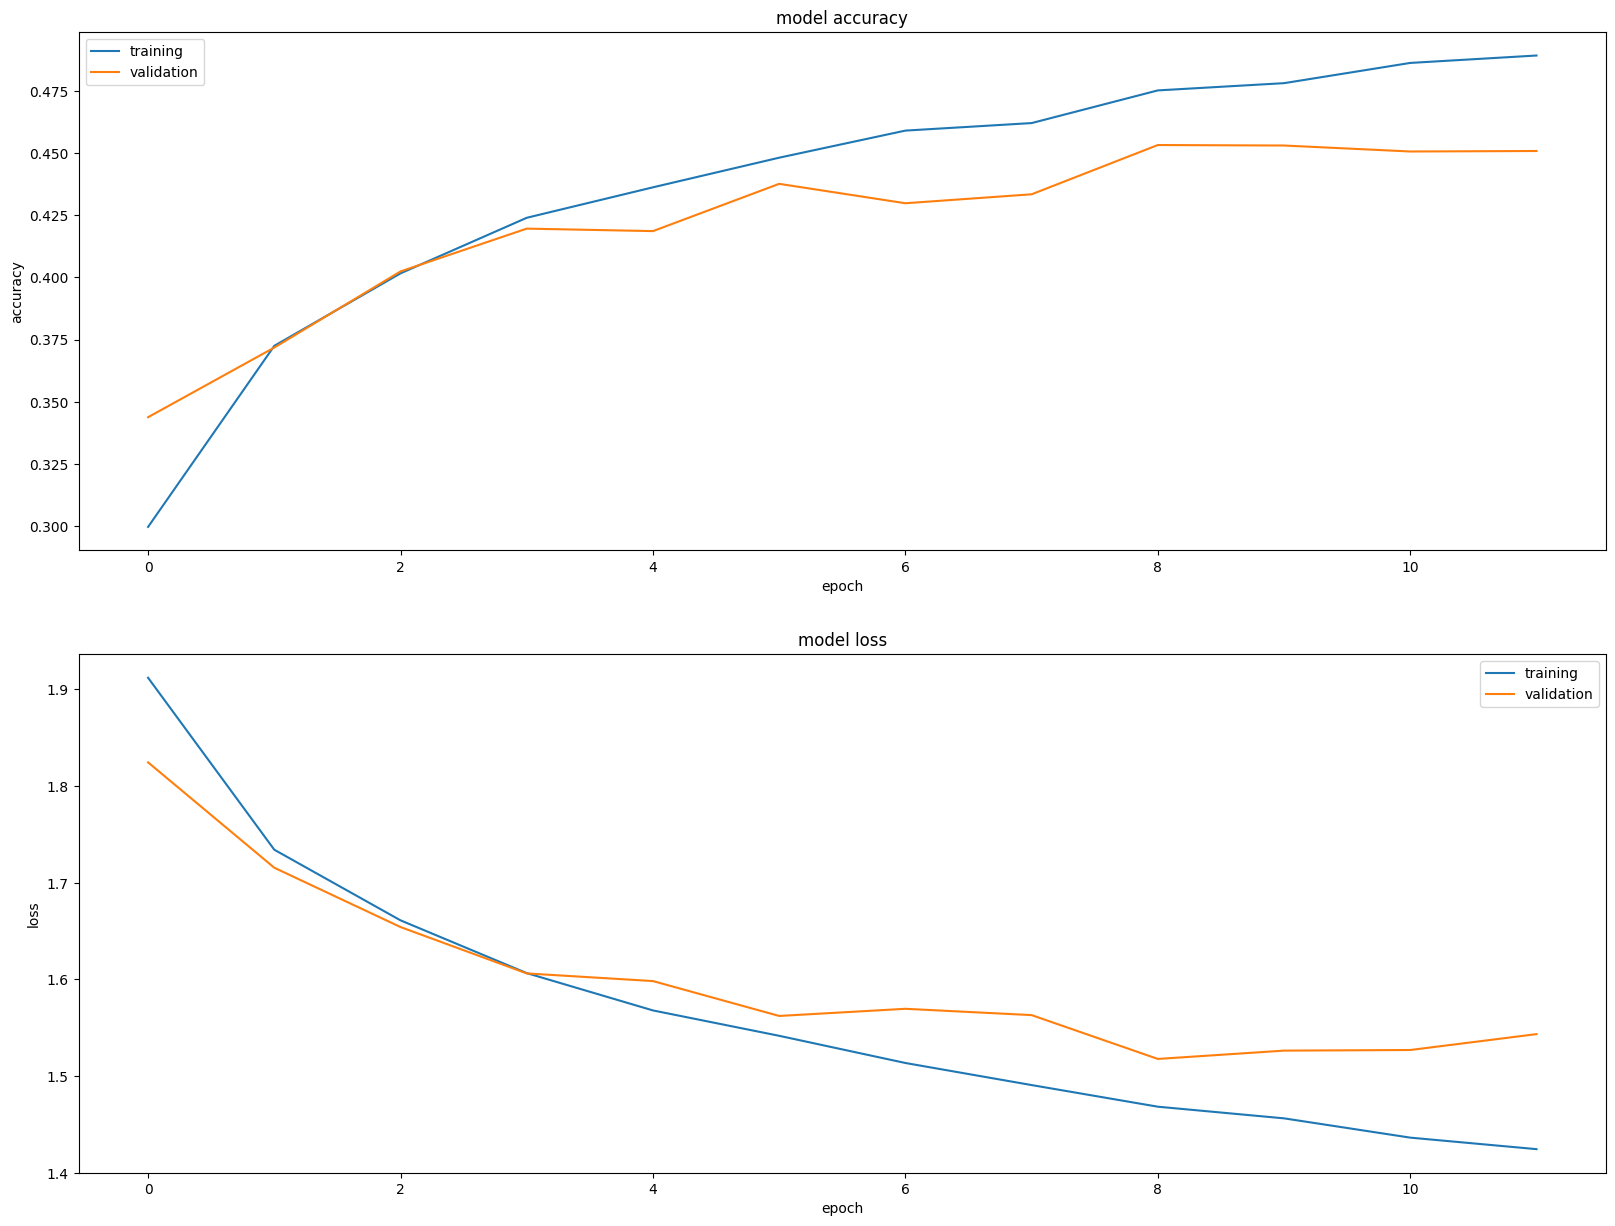

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)

## Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [ ]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 0s 1ms/step


In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.46      0.65      0.54      1000
           1       0.56      0.66      0.60      1000
           2       0.36      0.30      0.33      1000
           3       0.35      0.33      0.34      1000
           4       0.39      0.37      0.38      1000
           5       0.42      0.32      0.37      1000
           6       0.50      0.50      0.50      1000
           7       0.49      0.57      0.53      1000
           8       0.58      0.64      0.60      1000
           9       0.63      0.40      0.49      1000

    accuracy                           0.47     10000
   macro avg       0.47      0.47      0.47     10000
weighted avg       0.47      0.47      0.47     10000

Accuracy Score: 0.4741
Root Mean Square Error: 3.1831116851282486


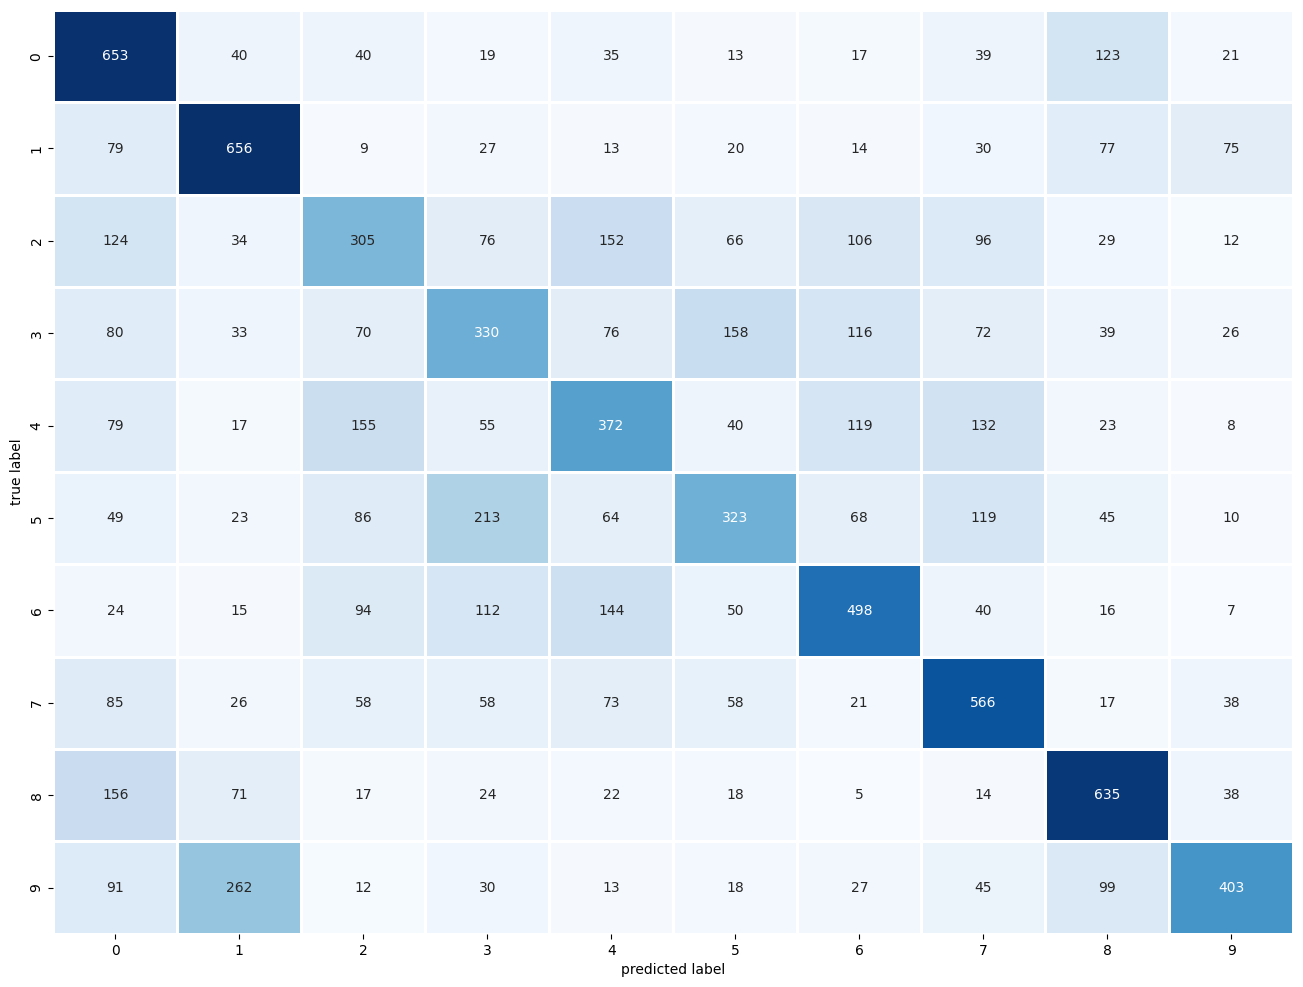

In [ ]:
plot_confusion_matrix(y_test,pred1)

## Load HDF5 Model Format

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model = tf.keras.models.load_model('DNN_model.h5')

In [ ]:
preds = model.predict(x_test_norm)

313/313 [==============================] - 1s 1ms/step


In [ ]:
preds.shape

(10000, 10)

## Predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,5.87%,3.80%,4.17%,24.46%,7.61%,33.93%,13.13%,3.57%,2.11%,1.35%
1,8.99%,29.04%,0.20%,0.29%,0.23%,0.09%,0.03%,0.10%,31.24%,29.79%
2,21.53%,12.49%,0.28%,0.39%,0.64%,0.18%,0.03%,0.20%,60.98%,3.28%
3,46.74%,5.45%,4.62%,1.41%,3.46%,1.03%,0.17%,1.09%,32.80%,3.23%
4,0.18%,0.03%,11.88%,2.39%,76.79%,2.44%,5.50%,0.68%,0.09%,0.03%
5,1.49%,1.92%,4.10%,15.95%,4.79%,6.36%,60.94%,2.36%,0.10%,1.99%
6,2.81%,6.79%,1.03%,22.85%,0.47%,56.75%,2.06%,6.64%,0.29%,0.31%
7,1.04%,0.41%,32.39%,12.44%,12.50%,9.28%,26.21%,4.91%,0.26%,0.55%
8,4.53%,0.36%,18.69%,19.20%,19.93%,23.30%,3.34%,9.61%,0.71%,0.33%
9,7.47%,56.43%,0.96%,1.50%,1.84%,0.40%,0.62%,0.46%,11.48%,18.84%


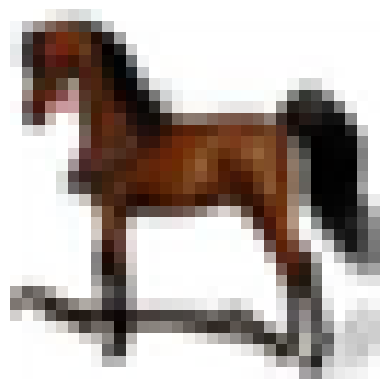

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

1/1 [==============================] - 0s 86ms/step


5

In [ ]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)

layer_names

['flatten', 'dense', 'dense_1', 'dense_2', 'dense_3']

1/1 [==============================] - 0s 72ms/step


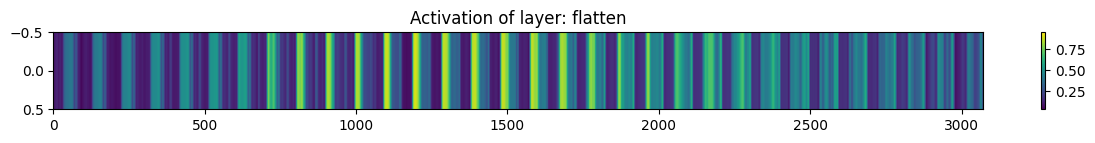

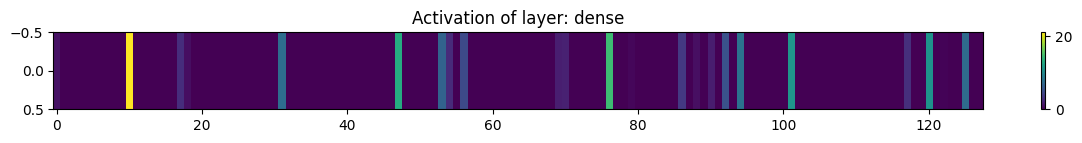

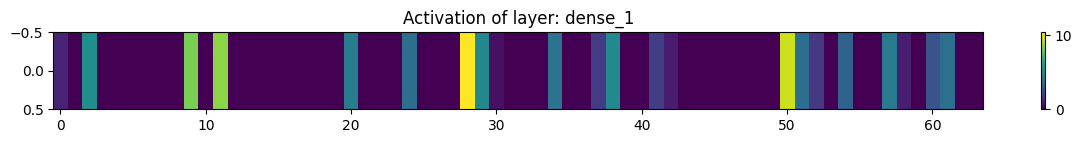

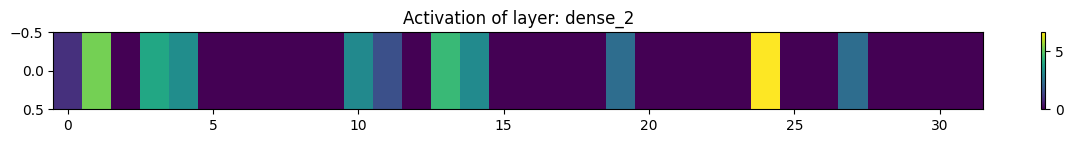

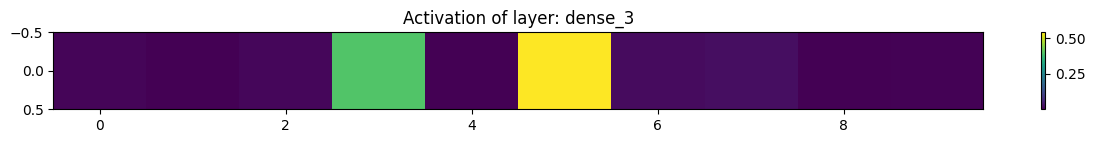

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model

# These are the names of all layers
layer_names = [layer.name for layer in model.layers]

# Create a new model that will output the activations of the specified layers
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Use a sample input to get the activations
sample_input = np.expand_dims(x_train_norm[0], axis=0)  # Use the first sample from your normalized training data
activations = activation_model.predict(sample_input)

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # Check the dimensionality of the layer activation
    if len(layer_activation.shape) == 2:  # Dense layer or Flatten layer output
        plt.figure(figsize=(15, 1))
        plt.imshow(layer_activation, aspect='auto', cmap='viridis')
        plt.title(f'Activation of layer: {layer_name}')
        plt.colorbar()
        plt.show()

plt.show()


In [ ]:
# Time Stamp
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

# Print the formatted time
print("Last Run:", formatted_time)

Last Run: 2024-06-11 18:05:11


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/458_Assignment_E2_A.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/458_Assignment_E2_A.ipynb to html
[NbConvertApp] Writing 1132883 bytes to /content/drive/MyDrive/Colab Notebooks/458_Assignment_E2_A.html
